In [69]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
import pylab

from time import time
from pprint import pprint
import pandas as pd
import numpy as np

from feature_extraction import Blob, Words
from calzone import grab_posts, describe

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Ridge

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.externals import joblib

import scipy.stats as stats

# Steps 1 - 4
1.  Reads in csv-formatted subreddit data.  
    1a. You can use the grab_posts function to collect posts inline
2.  Optional: Data transformation  
    2a. Obtain normal distribution of upvotes by applying log transformation.  
    2b. Remove outliers using z-scores greater than -2.5 and less than 2.5
3.  Create labeled data (It is the boolean set to whether or not a title will receive more than average number of upvotes )
4.  Split data into training and test 

In [61]:
#Read in posts

data = pd.read_csv('processed_datascience.csv.bz2')

# You can use the grab_posts module if you want to grab posts from specific subreddits and time-frames
# To retrieve your own posts requires a reddit developer account
#from calzone import grab_posts
#data = grab_posts(sub='todayilearned', start='01/24/2018', end='02/05/2018', number=30000, verbose=True)


## Optional: Throw out outliers by including rows with Z-Scores less than 2.5 and greater than -2.5
#data['z_scores'] = np.abs((data.ups-data.ups.mean())/data.ups.std())
#data = data[data['z_scores']<= 2.5]

## Optional: Log transformation of up-votes
data['log_ups'] = np.log1p(data['ups'])

# Use log transformed votes as the label column 
train_X, test_X, train_y, test_y = train_test_split(data.title, 
                                                    data.log_ups, 
                                                    test_size=0.20,
                                                    random_state=42)

print('AVERAGE UPVOTES: ', '{:03.1f}'.format(data.ups.mean()))

AVERAGE UPVOTES:  9.9


### Let's take a look at the imported data

#### Description of Data

The attributes are:
    1.  The longest title (characters)
    2.  The average length of a title (characters)
    3.  The max number of words found in a title
    4.  The average number of words in a title
    5.  The average number of noun phrases found in titles
    6.  The average subjectivity of the titles - ranging from 0(objective) to 1(subjective)
    7.  The average polarity of the titles: -1(negative) to 0(neutral) to 1(positive)
    8.  The average number of votes per title

In [62]:
num_of_titles = len(data['title'])
print('Total Number of Titles in Dataset:', num_of_titles)
results = describe(data) # calzone function to extract title attributes
display(results.loc['All'])

Total Number of Titles in Dataset: 8856


Max_Title         299.000000
Avg_Title          58.000000
Max_Word_Count     58.000000
Avg_Word_Count      9.000000
Noun_Phrases        2.285117
Subjectivity        0.193523
Polarity            0.078142
Avg_Votes           9.870709
Name: All, dtype: float64

### Statistical Description of Data

Exploratory Stats for Upvotes
count    8856.000000
mean        9.870709
std        21.516689
min         0.000000
25%         1.000000
50%         4.000000
75%         9.000000
max       552.000000
Name: ups, dtype: float64



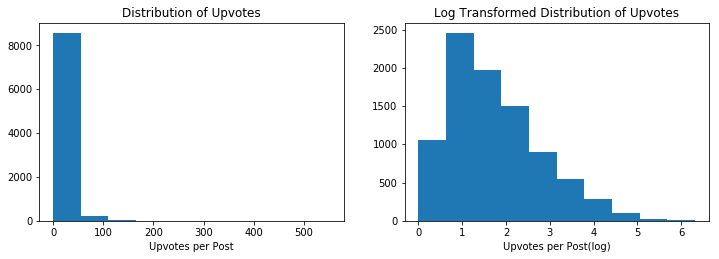

In [63]:
# Stats for Upvotes
print('Exploratory Stats for Upvotes')
print(data.ups.describe())
print()


# Distribution of Upvotes
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.title('Distribution of Upvotes')
plt.hist(data['ups'])
plt.xlabel('Upvotes per Post')

plt.subplot(2,2,2)
plt.title('Log Transformed Distribution of Upvotes')
plt.hist(data['log_ups'])
plt.xlabel('Upvotes per Post(log)')
plt.show()


### Graph a probability plot

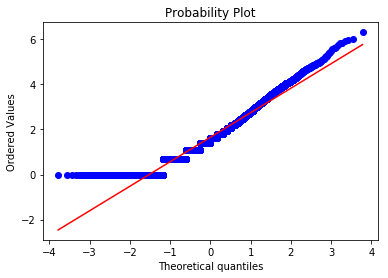

In [64]:
stats.probplot(data['log_ups'], dist="norm", plot=pylab)
pylab.show()

# Step 5-7:  
The workflow pipeline consists of two segments. The first is feature extraction, decomposition,and reduction. The second is training a classifier.  A quick reminder, all feature information is derieved from the title of each post.
5.  Feature Extraction
    
    1.  words:
            Creates a dataframe containing the number of the following in each title:
                1. Consonants - the number of consonants in each title
                2. Vowels - the number of vowels in each title
                3. Words - the number of words in each title
                4. Characters - the number of characters in each title
    2.  blob:
            Creates a dataframe containing the following characteristics of each title
                1. Noun Phrases - a count of the number of noun phrases in each title
                2. Subjectivity - Objectivity vesus Subjectivity(range 0 to 1)
                3. Polarity - Negative(-1), Neural(0), or Positive(1) Sentiment(ranging from -1 to 1)
    3.  title:
            Vectorizes text, decomposes vector, and select features.  
                1. Tf-idf
                    A. Creates a word vector in which a word is weighted by its occurence not only in the title it was derived from but also the entire corpus.
                    B.  Use uni-grams to tri-grams, english stop_words, and sublinear term frequency(tf)
                        1.  Sublinear tf: Uses the logarithm of the term frequency instead of simple tf
                2.  TruncatedSVD reduces features through LSA decomposition
                3.  SelectPercentile selects the top 10% of features that improve prediction

6.  Classifier:  ExtraTreesClassifier
    1.  I choose this classifier for its speed.  
    2.  I examined other classifiers but the results were pretty much the same.  

7.  Final Steps
    1.  Generate prediction model by fitting on training data
    2.  Use model to predict test data labels
    3.  Measure prediction accuracy
    4.  Cross validate prediction, This is primarily a way of measuring the predictive performance of a statistical model
    5.  Improved by tuning hyperparameters, see [here](hyperparameters.ipynb)
        1.  However in this instance, tuning only resulted in slight improve (1%)

#### *** SPECIAL NOTE ***
1.  Collinearity can be used to determine which features to include in analysis (see [here](colinearity.ipynb))
    1.  Despite the correlation results, I choose to use all the features described above

In [65]:
# Sklearn has a pipeline Class that directs the flow of model creation; below the pipeline corals the features into the ExtraTrees classifer.
# Within the pipeline is a sklearn Class called FeatureUnion.  Feature Union allows for the joining of multiple features into a single vector
# Within the feature union is a transformer list containing classes that performed the functions described above
# The final pipeline item is the declaration of a classifier that the feature vector will be inserted into

pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
                      
            ('words', Words()),
                      
            ('title', Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True, stop_words='english')),
                ('svd', TruncatedSVD(n_components=120)),
                ('normalize', MinMaxScaler(copy=False)),
                ('selector', SelectPercentile(f_classif, percentile=10))
            ])),
            
            ('blob', Pipeline([
                ('all', Blob()),
                ('minmax', MinMaxScaler()),
            ])),
            
            ])),
    ('clf', Ridge()),
        ])

# Train model
pipeline.fit(train_X, train_y)

# Predict Test Set
y_pred = pipeline.predict(test_X)

In [66]:
# Measure prediction Accuracy
error = mean_absolute_error(y_pred=y_pred, y_true=test_y)
print('Error: {:03.1f} votes'.format(np.expm1(error)))

Error: 1.4 votes


In [67]:
# Test it out!
index = 2
answer = pipeline.predict(pd.Series(['A Gentle Introduction to N-Dimensional Arrays in Python with NumPy - Machine Learning Mastery']))[0]
np.expm1(answer)

8.2934835588186733

In [70]:
# Save our model
joblib.dump(pipeline, 'datascience_regressor.pkl')

['datascience_regressor.pkl']